In [66]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats import weightstats as stests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import numpy as np
import warnings
warnings.simplefilter('ignore')
%run -i 'functions.py'

# EWR Weather in 2019

In [2]:
pd.set_option('display.max_columns', None)
df= pd.read_csv('ewrweather.csv')

We are going to clean and organize the data and columns into a legible dataset which will be useful for visuals and models. 

## Cleaning the dataset

In [3]:
df['date']= pd.date_range(start='1/1/2019', end='12/31/2019')

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

In [6]:
df['season'] = df.date.map(season_of_date)

In [7]:
df['month'] = df['date'].dt.month

In [8]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['precipAccumulation'].fillna(0,inplace=True)

After cleaning the dataset we filled in the null values in 'PrecipAccumulation' because the null values indicate no accumulation due to snow. 

In [12]:
df['icon'].value_counts()

rain                 148
partly-cloudy-day    137
clear-day             50
snow                  11
wind                   5
cloudy                 4
Name: icon, dtype: int64

In [13]:
df['precipType'].value_counts()

rain    210
snow     25
Name: precipType, dtype: int64

In [14]:
df.to_csv('cleanEWRweather.csv')

# Visuals

### Precipitation 

In [15]:
rain = df.groupby('season').agg({'precipProbability': ['mean']})
rain

,precipProbability
,mean
season,
1,0.393778
2,0.450674
3,0.357234
4,0.549565


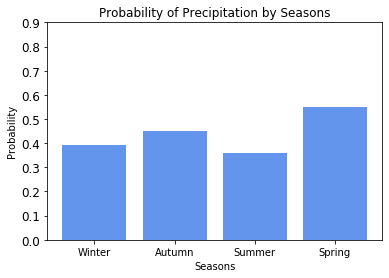

In [16]:
avgrain(rain)

The visual for precipitation is very similar to JFK, New York as they are close in distance. The weather data will be fairly similar in both locations.

#### ANOVA 

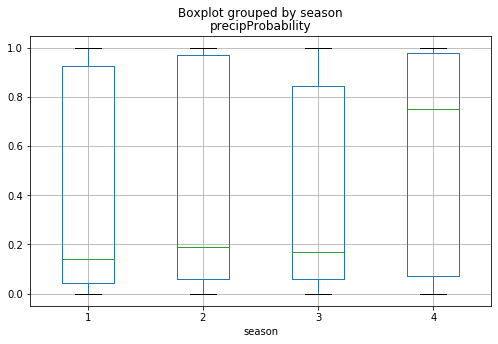

In [61]:
df.boxplot('precipProbability', by='season', figsize=(8, 5))

- Ha : There is no statistically significant difference in chance of precipitaton from the four seasons.
- Ho : There statistically significant difference in chance of precipitaton from the four seasons.

In [67]:
anova(df)

             df     sum_sq   mean_sq         F    PR(>F)
season      3.0   1.948493  0.649498  3.726993  0.011583
Residual  361.0  62.910939  0.174269       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0569 0.7737 -0.1042  0.218  False
     1      3  -0.0365    0.9 -0.1955 0.1224  False
     1      4   0.1558  0.059  -0.004 0.3155  False
     2      3  -0.0934 0.4319 -0.2528 0.0659  False
     2      4   0.0989 0.3848 -0.0613 0.2591  False
     3      4   0.1923 0.0098  0.0343 0.3504   True
---------------------------------------------------


According to the results we can see the pvalue for the ANOVA test is less than our alpha of 0.05 therefore we can conclude there is a significant difference between the probability of precipitaion in seasons. We conduct a Tukey multiple pairwise- comparison to identify where the difference occurs.
Looking at each season we can see there was no statistically signifance difference in comparing winter and autumn with the other seasons therefore we can assume there is not enough evidence to compare winter and autumn with the other two seasons. But when comparing spring and summer with each other there is statistical significance therefore the result is not attributed by  chance.

### Temperature

In [17]:
df['avgtemp']= df[['temperatureMax','temperatureMin']].mean(axis=1)

In [18]:
temp = df.groupby('season').agg({'avgtemp': ['mean']})
temp

,avgtemp
,mean
season,
1,35.313778
2,50.705955
3,76.361755
4,59.912826


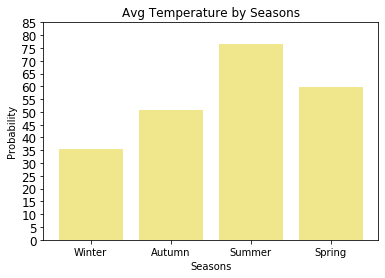

In [19]:
avgtemp(temp)

Again, we can identify the season with the highest average temperature is summer. 

# Analysis of Weather Delays

In the EWR notebook, I have identified the dates with the longest delays due to weather conditions. Below are the top 3 dates in which had the longest dates. These dates are actualy different from JFK delayed dates. 

In [22]:
airport= pd.read_csv('final1.csv')
airport.drop(['Unnamed: 0'],axis=1,inplace=True)
EWR = airport[airport['ORIGIN_STATE_ABR'] == 'NJ']

In [23]:
EWR[EWR['WEATHER_DELAY'] > 0].groupby(['FL_DATE']).size().nlargest(3)

FL_DATE
2019-02-20    6
2019-06-20    6
2019-12-01    6
dtype: int64

### 2019-02-20

In [24]:
EWR[(EWR['FL_DATE'] =='2019-02-20')].groupby(['OP_UNIQUE_CARRIER']).size()


OP_UNIQUE_CARRIER
AS     2
UA    10
dtype: int64

On this date only 12 flights travel to Los Angeles. Out of those 12 flights only half were delayed and those delayed flights are from United Airlines.

In [26]:
EWR[(EWR['FL_DATE'] =='2019-02-20') & (EWR['WEATHER_DELAY'] > 0)].groupby(['OP_UNIQUE_CARRIER']).size()

OP_UNIQUE_CARRIER
UA    6
dtype: int64

In [27]:
EWR[(EWR['FL_DATE'] =='2019-02-20') & (EWR['WEATHER_DELAY'] > 0)].groupby(['OP_UNIQUE_CARRIER']).agg({'WEATHER_DELAY': ['sum']})

,WEATHER_DELAY
,sum
OP_UNIQUE_CARRIER,
UA,942.0


United Airlines has the largest delay time due to weather. The 6 flights were delayed with a total of 942 minutes!

In [43]:
EWR[(EWR['FL_DATE'] =='2019-02-20') & (EWR['WEATHER_DELAY'] > 0)]

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,delayed,ontime,cancel,class,delay_carrier,delay_weather,delay_nas,delay_security,delay_late_aircraft
26396,1,2,20,3,2019-02-20,UA,1871,11618,EWR,"Newark, NJ",NJ,New Jersey,12892,LAX,"Los Angeles, CA",CA,California,50.0,350.0,500.0,398.0,0.0,363.0,2454.0,0.0,59.0,48.0,0.0,291.0,True,False,False,2,False,True,True,False,True
26397,1,2,20,3,2019-02-20,UA,1600,11618,EWR,"Newark, NJ",NJ,New Jersey,12892,LAX,"Los Angeles, CA",CA,California,1742.0,42.0,2205.0,105.0,0.0,348.0,2454.0,0.0,42.0,63.0,0.0,0.0,True,False,False,2,False,True,True,False,False
26400,1,2,20,3,2019-02-20,UA,1156,11618,EWR,"Newark, NJ",NJ,New Jersey,12892,LAX,"Los Angeles, CA",CA,California,1212.0,12.0,1606.0,45.0,0.0,347.0,2454.0,0.0,12.0,33.0,0.0,0.0,True,False,False,2,False,True,True,False,False
26402,1,2,20,3,2019-02-20,UA,751,11618,EWR,"Newark, NJ",NJ,New Jersey,12892,LAX,"Los Angeles, CA",CA,California,1622.0,22.0,2022.0,59.0,0.0,352.0,2454.0,0.0,22.0,37.0,0.0,0.0,True,False,False,2,False,True,True,False,False
26408,1,2,20,3,2019-02-20,UA,275,11618,EWR,"Newark, NJ",NJ,New Jersey,12892,LAX,"Los Angeles, CA",CA,California,1120.0,1040.0,1451.0,1054.0,0.0,367.0,2454.0,0.0,761.0,14.0,0.0,279.0,True,False,False,2,False,True,True,False,True
26552,1,2,20,3,2019-02-20,UA,2394,11618,EWR,"Newark, NJ",NJ,New Jersey,12892,LAX,"Los Angeles, CA",CA,California,1446.0,46.0,1856.0,99.0,0.0,355.0,2454.0,0.0,46.0,53.0,0.0,0.0,True,False,False,2,False,True,True,False,False


In [29]:
df[df['date']== '2019-02-20']

,date,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,precipAccumulation,season,month,avgtemp
50,2019-02-20,1550552400,Partly cloudy throughout the day.,partly-cloudy-day,1550576820,1550615820,0.52,0.0,0.0001,1.550585e+09,0.03,NaN,37.72,1550606400,26.24,1550666160,29.38,1550606340,19.45,1550665260,6.83,0.39,1033.8,10.03,16.91,1550613600,313,0.37,3,1550598660,10.0,304.7,22.26,1550575800,37.72,1550606400,13.23,1550573940,29.38,1550606340,0.0,1,2,29.99


According to the weather data in EWR we can see there is low chance of rain on this date. In addition, there is not evidence of precipitation due to snow. Let's look into the weather in LAX on this date to see if the delay was due to weather in the destination. 

In [30]:
LAX = pd.read_csv('cleanlaxweather.csv')

In [31]:
LAX[LAX['date']== '2019-02-20']

,Unnamed: 0,date,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,season,month,avgtemp
50,50,2019-02-20,1550563200,Clear throughout the day.,clear-day,1550586900,1550626920,0.52,0.0002,0.0007,1550645640,0.05,rain,58.7,1550609040,44.39,1550657580,58.2,1550609040,42.07,1550656980,27.86,0.4,1020.0,7.25,15.26,1550566860,295,0.02,5,1550606580,10.0,327.7,45.58,1550587500,58.7,1550609040,42.24,1550584080,58.2,1550609040,1,2,52.14


It seems that in LAX the sky was clear. There is no evidence of rain in either locations. My guess is there might have been weather delays in the Midwest. 

### 2019-06-20

In [33]:
EWR[(EWR['FL_DATE'] =='2019-06-20')].groupby(['OP_UNIQUE_CARRIER']).size()

OP_UNIQUE_CARRIER
AS     3
UA    12
dtype: int64

On this date there were only 15 flights that travel to LAX. It seems that Alaska Airlines only has 3 flights with destination to LAX.  

In [38]:
EWR[(EWR['FL_DATE'] =='2019-06-20') & (EWR['WEATHER_DELAY'] > 0)].groupby(['OP_UNIQUE_CARRIER']).size()

OP_UNIQUE_CARRIER
UA    6
dtype: int64

In [39]:
EWR[(EWR['FL_DATE'] =='2019-06-20') & (EWR['WEATHER_DELAY'] > 0)].groupby(['OP_UNIQUE_CARRIER']).agg({'WEATHER_DELAY': ['sum']})

,WEATHER_DELAY
,sum
OP_UNIQUE_CARRIER,
UA,210.0


It seems that United Airlines had a total of delay of 210 minutes of all the 6 flights. 

In [41]:
df[df['date']== '2019-06-20']

,date,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,precipAccumulation,season,month,avgtemp
170,2019-06-20,1560916800,Rain throughout the day.,rain,1560936420,1560990720,0.59,0.0041,0.0567,1.560978e+09,0.95,rain,72.06,1560969540,65.63,1561026960,72.29,1560969960,67.13,1561026960,66.01,0.91,1010.4,5.18,8.81,1560964260,100,1.0,4,1560963300,5.503,329.4,65.82,1560997320,72.06,1560969540,67.32,1560997320,72.29,1560969960,0.0,4,6,68.94


According to the weather data of EWR, it shows that on June 20,2019 it rained throughout the day. There was a 95% chance of rain with low visibity of 5.5 miles. In addition, cloud coverage is at its full with 100% of sky coveraged.

### 2019-12-01

In [45]:
EWR[(EWR['FL_DATE'] =='2019-12-01')].groupby(['OP_UNIQUE_CARRIER']).size()

OP_UNIQUE_CARRIER
AS     2
UA    14
dtype: int64

On this date EWR had a total of 16 flights traveling to LAX. Out of all the 16 flights only 6 of the flights were delayed. 

In [46]:
EWR[(EWR['FL_DATE'] =='2019-12-01') & (EWR['WEATHER_DELAY'] > 0)].groupby(['OP_UNIQUE_CARRIER']).size()

OP_UNIQUE_CARRIER
UA    6
dtype: int64

In [47]:
EWR[(EWR['FL_DATE'] =='2019-12-01') & (EWR['WEATHER_DELAY'] > 0)].groupby(['OP_UNIQUE_CARRIER']).agg({'WEATHER_DELAY': ['sum']})

,WEATHER_DELAY
,sum
OP_UNIQUE_CARRIER,
UA,162.0


The 6 flights that were delayed in EWR were delayed a total of 162 minutes. 

In [48]:
df[df['date']== '2019-12-01']

,date,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,precipAccumulation,season,month,avgtemp
334,2019-12-01,1575090000,Partly cloudy throughout the day.,partly-cloudy-day,1575115320,1575149520,0.15,0.0,0.0003,1.575173e+09,0.06,NaN,45.18,1575142680,27.94,1575204060,42.08,1575140520,18.62,1575202020,15.45,0.43,1017.7,8.3,13.97,1575112980,349,0.56,2,1575132300,10.0,341.7,29.74,1575115200,45.18,1575142680,19.84,1575115080,42.08,1575140520,0.0,2,12,37.46


On this date in EWR there was low chance of precipitation with low cloud coverage. It seems that the flights were not delayed on this date because of rain or cloudy skys. Lets look into the weather of the destination, there is a chance the weather delay could be in LAX.

In [49]:
LAX[LAX['date']== '2019-02-20']

,Unnamed: 0,date,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,precipType,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,dewPoint,humidity,pressure,windSpeed,windGust,windGustTime,windBearing,cloudCover,uvIndex,uvIndexTime,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,season,month,avgtemp
50,50,2019-02-20,1550563200,Clear throughout the day.,clear-day,1550586900,1550626920,0.52,0.0002,0.0007,1550645640,0.05,rain,58.7,1550609040,44.39,1550657580,58.2,1550609040,42.07,1550656980,27.86,0.4,1020.0,7.25,15.26,1550566860,295,0.02,5,1550606580,10.0,327.7,45.58,1550587500,58.7,1550609040,42.24,1550584080,58.2,1550609040,1,2,52.14


According to the weather in LAX, the delay does not seem to be because of the destination. In Los Angeles, there was clear skies and low chance of rain. I would infer that the delay in weather might be because of the states' in between the two location. The Midwest may have serious weather conditions in which affect the delay of the flights. 